# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

## Dataset

Load, analyze, feature engineer and feature creation.

Apriori knowledge:
- 20 Years data, 2003-2022
- 2015 economic shift, with a steep upward trend on measures.
- 2020 blackswan event, breaking trend. Trends is realigned on 2021.
- Data is a timeseries, with monthly intervals.
- Data has a unit root, with a rising trend due to population, industry and climate increase.
- Data hasa seasonality with low demand at spring and autum, and highest demand end of summer.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt


DATA_PATH = "./data"


END_DATE = datetime(2022, 12, 31)

train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
test_df = test_df[test_df.index <= END_DATE]


print(f"Shapes: train_df: {train_df.shape} test_df: {test_df.shape}")


test_df.head(12)

Shapes: train_df: (192, 10) test_df: (48, 10)


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tmin,tavg,tmax
Date,,,,,,,,,,
2019-01-01,0.44,224.76,46.96,10.45,75.11,14.19,504.06,8.8,11.6,14.4
2019-02-01,0.43,199.54,60.59,11.93,73.41,14.19,504.06,8.7,12.0,15.3
2019-03-01,0.39,199.28,58.86,16.83,66.58,14.19,504.06,11.2,14.5,17.7
2019-04-01,0.36,186.04,44.68,17.85,61.46,14.19,504.06,12.6,15.9,19.1
2019-05-01,0.33,189.43,34.20,21.52,56.34,14.19,504.06,14.3,18.3,22.3
2019-06-01,0.45,231.40,45.46,22.85,76.82,14.19,504.06,21.3,26.3,31.4
2019-07-01,0.50,278.55,82.34,23.40,85.36,14.19,504.06,23.2,27.5,32.6
2019-08-01,0.48,283.84,69.46,21.64,81.94,14.19,504.06,23.8,28.2,32.5
2019-09-01,0.43,238.35,68.75,18.01,73.41,14.19,504.06,22.0,25.6,29.1


## Baseline Model

We know its a timeseries, seasonal and not stationary. Let's observe this in the data:

<Figure size 1200x600 with 0 Axes>

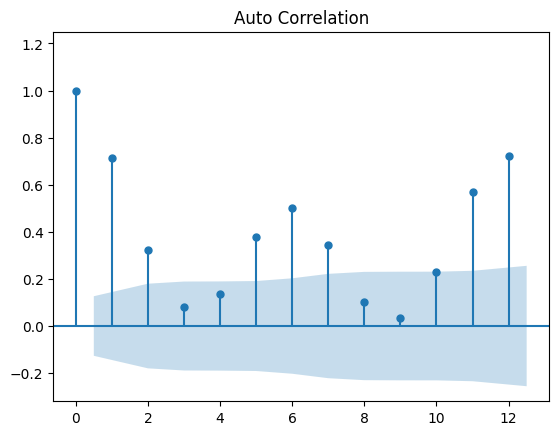

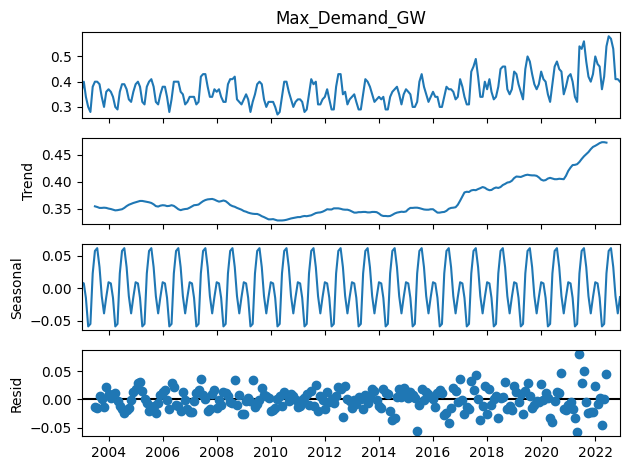

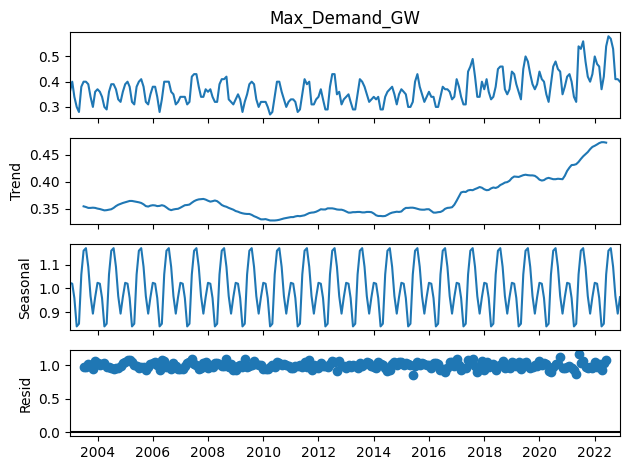

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

FEATURES = [
    "Population_k",
    "tmax",
    "GDP_bln",
    "Plant_Production_GWh",
    "emissions_c02_GG",
]
TARGET = "Max_Demand_GW"
INDEX = "Date"
TIME_WINDOW = 1
LAGS = 1

data_ts = pd.concat([train_df[TARGET], test_df[TARGET]])

plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(
    data_ts,
    lags=LAGS * 12,
    auto_ylims=True,
    title="Auto Correlation",
)

a_season = seasonal_decompose(data_ts, model="a", period=12)
m_season = seasonal_decompose(data_ts, model="m", period=12)
fig = a_season.plot()
fig = m_season.plot()
plt.show()

First plot is ACF:
- There is significant autoregression at lag 1,2, 11,12 between a pearson of  6 o 8.

Second plots:
- Addition is noise, shows that there is no linear relation.
- Multiplicative is straightforward

Therefore it needs its  unitroot removed, and its seasonality wieghts extracted.
Doing this will produce a 'flat' timeseries below:

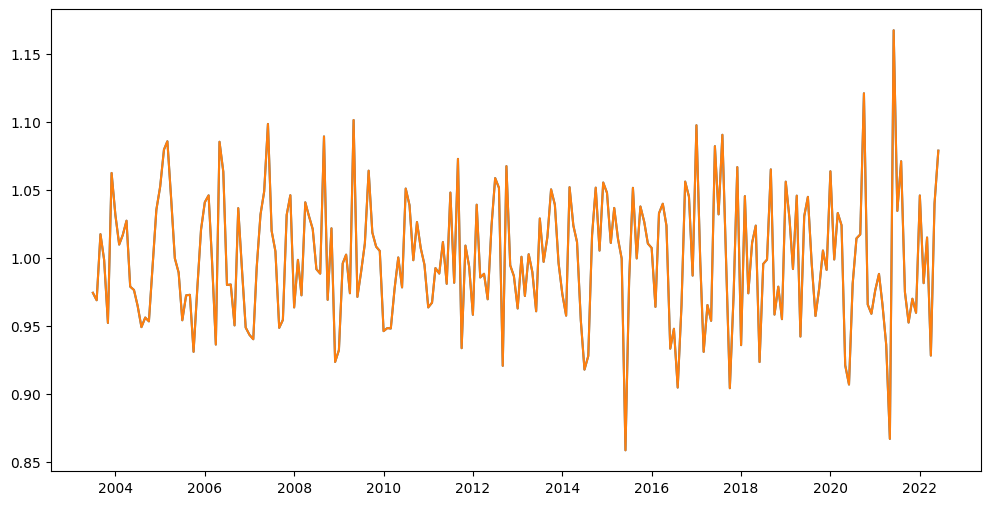

In [3]:
flat_target = data_ts.values / m_season.seasonal / m_season.trend

plt.figure(figsize=(12, 6))
plt.plot(data_ts.index, flat_target, flat_target)
plt.show()

Finally we verify test the Null Hypothesis (H0) that the data is not stationary, using an augmented Dickey–Fuller test (ADF). 

We see that the T statistic and P-valuue are positive and large, meaning H0 is not rejected and our data is not stationary and has a unit root.

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_ts.values)
print("T-stat: %f" % result[0])
print("p-value: %f" % result[1])

T-stat: 0.212656
p-value: 0.972963


In [5]:
from statsmodels.tsa.vector_ar.vecm import select_order
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.arima import auto_arima

# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima
train_df.index.names = [INDEX]
arima = Pipeline(
    [
        ("boxcox", BoxCoxEndogTransformer(lmbda=0)),
        (
            "arima",
            auto_arima(
                y=train_df[TARGET],
                d=TIME_WINDOW,  # Diffs
                stationary=False,  # Has a trend
                start_p=LAGS,  # Lag
                m=12,  # Monthly seasonality
                seasonal=True,
                maxiter=30,
                with_intercept=True,
                information_criterion="bic",
                scoring="mse",
                stepwise=True,
                error_action="ignore",
                trace=True,
            ),
        ),
    ]
)

arima.fit(train_df[TARGET])
fc, co_int = arima.predict(
    n_periods=12 * 4, return_conf_int=True, inverse_transform=True
)  # 4 Years

Performing stepwise search to minimize bic
 ARIMA(1,1,2)(1,0,1)[12] intercept   : BIC=-864.496, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-695.908, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-805.792, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-742.506, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-701.160, Time=0.07 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : BIC=-783.631, Time=1.13 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : BIC=-832.650, Time=0.77 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : BIC=-854.479, Time=1.87 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : BIC=-848.862, Time=2.22 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : BIC=-747.561, Time=0.66 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : BIC=-791.200, Time=1.98 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : BIC=-863.842, Time=1.17 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : BIC=-862.870, Time=1.85 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : BIC=-859.963, Time=0.65 sec
 ARIMA(1,1,1)(1,0,1

RMSE: 0.05
SMAPE: 9.62%


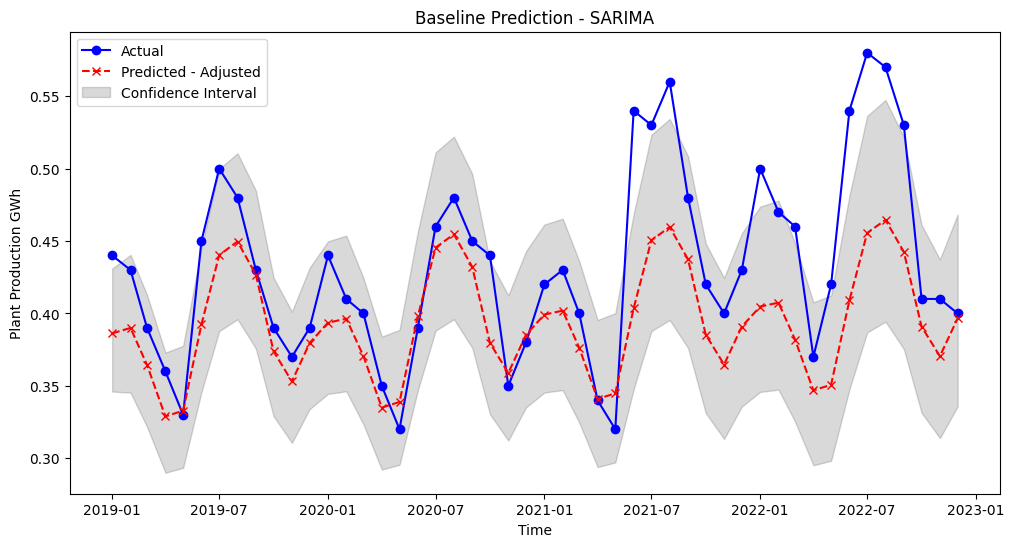

In [6]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

print(f"RMSE: {mean_squared_error(test_df[TARGET], fc, squared=False):0.02f}")
print(f"SMAPE: {smape(test_df[TARGET], fc):0.02f}%")

plt.figure(figsize=(12, 6))
plt.plot(test_df[TARGET], label="Actual", color="blue", marker="o")
plt.plot(
    test_df[TARGET].index,
    fc,
    label="Predicted - Adjusted",
    color="red",
    linestyle="dashed",
    marker="x",
)
plt.fill_between(
    test_df.index,
    co_int[:, 0],
    co_int[:, 1],
    color="k",
    alpha=0.15,
    label="Confidence Interval",
)

plt.xlabel("Time")
plt.ylabel("Plant Production GWh")
plt.title("Baseline Prediction - SARIMA")
plt.legend()
plt.show()

In [7]:
m_season_adjust = seasonal_decompose(train_df[TARGET], model="m", period=12)
df_adjustment = pd.DataFrame(
    {
        "Seasonal": m_season_adjust.seasonal,
        "Trend": m_season_adjust.trend,
        "Month": train_df.index.month,
    }
)

df_adjustment = df_adjustment.groupby("Month").mean()
df_adjustment.reset_index(inplace=True)

# Save weights for future prediction
df_adjustment.to_pickle(f"{DATA_PATH}/seasonal_adjustment.pkl")
df_adjustment

,Month,Seasonal,Trend
0,1,1.014407,0.351694
1,2,1.020556,0.352000
2,3,0.960149,0.352361
3,4,0.845501,0.352639
4,5,0.866018,0.352861
5,6,1.046050,0.353028
6,7,1.154040,0.350861
7,8,1.162794,0.350917
8,9,1.089525,0.351000
9,10,0.968123,0.351139


Givens:
- This is a multivariate TS of pop, temp, demand, industry signals.
- Assume these are asynchronous, therefore noisy

Data DIM:
- 0: Sequences
- 1: Data in sequence
- 2: Features for that datum (AKA channels for COV1D)

In [8]:
def encode_lagged_timeseries(data_df, window=TIME_WINDOW, lag=LAGS):
    sequences, features = list(), list()
    for i in range(window, 0, -1):
        sequences.append(data_df.shift(i))
        features += [("%s(t-%d)" % (col, i)) for col in data_df.columns]

    sequences.append(data_df)
    features += [("%s(t)" % (col)) for col in data_df.columns]

    # the target label - next month if lag is 1
    sequences.append(data_df.shift(-lag))
    features += [("%s(t+%d)" % (col, lag)) for col in data_df.columns]

    ts_df = pd.concat(sequences, axis=1)
    ts_df.columns = features
    ts_df.dropna(inplace=True)

    return ts_df


train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

# Values are too low for this NN, descale from GW to MW.
# Further feature engineering will be done on these DFs.
train_df_scaled[TARGET] = train_df_scaled[TARGET] * 100
test_df_scaled[TARGET] = test_df_scaled[TARGET] * 100

X = encode_lagged_timeseries(train_df_scaled[FEATURES])
y = encode_lagged_timeseries(train_df_scaled[[TARGET]])
Xt = encode_lagged_timeseries(test_df_scaled[FEATURES])
yt = encode_lagged_timeseries(test_df_scaled[[TARGET]])

print(f"Train -> X Shape: {X.shape} y Shape: {y.shape} ")
print(f"Testt -> X Shape: {Xt.shape} y Shape: {yt.shape} ")
X.head(2)

Train -> X Shape: (190, 15) y Shape: (190, 3) 
Testt -> X Shape: (46, 15) y Shape: (46, 3) 


,Population_k(t-1),tmax(t-1),GDP_bln(t-1),Plant_Production_GWh(t-1),emissions_c02_GG(t-1),Population_k(t),tmax(t),GDP_bln(t),Plant_Production_GWh(t),emissions_c02_GG(t),Population_k(t+1),tmax(t+1),GDP_bln(t+1),Plant_Production_GWh(t+1),emissions_c02_GG(t+1)
Date,,,,,,,,,,,,,,,
2003-02-01,398.58,15.6,4.82,182.08,47.52,398.58,13.0,4.82,187.10,52.80,398.58,15.7,4.82,176.37,44.88
2003-03-01,398.58,13.0,4.82,187.10,52.80,398.58,15.7,4.82,176.37,44.88,398.58,18.7,4.82,156.53,39.60


In [9]:
X_series = X.values.reshape((X.shape[0], X.shape[1], 1))
Xt_series = Xt.values.reshape((Xt.shape[0], Xt.shape[1], 1))

y_series = y.values.reshape((y.shape[0], y.shape[1], 1))
yt_series = yt.values.reshape((yt.shape[0], yt.shape[1], 1))

print(f"Altered shapes: train: {X_series.shape} test: {Xt_series.shape}")

Altered shapes: train: (190, 15, 1) test: (46, 15, 1)


# Convolution Neural Networks

CNNs, RNNs and other stateful deeplearning models are used for timeseries (including transformers, as language is also a timeseries).

Here is a basic architecutre:
1. Input of the lagged timeseries data
2. a convoluton layer
3. a pooling layer to reduce dimentionality
4. hidden dense layers to capture patterns and relationships
5. a dropout to reduce overfitting
6. a single output layer for continuous predictions.
7. ADAM learning optimizer
8. Fast stop function on best loss.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Input, MaxPooling1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 95
BATCH_SIZE = 32
FILTER = 128
DROPRATE = 0.2
POOL_SIZE = 2
K_SIZE = 8

model = Sequential(
    [
        Input(shape=(X_series.shape[1], X_series.shape[2])),
        Conv1D(FILTER, kernel_size=K_SIZE, activation="relu"),
        MaxPooling1D(pool_size=POOL_SIZE),
        Flatten(),
        Dense(60, activation="relu"),
        Dense(15, activation="relu"),
        Dropout(DROPRATE),
        Dense(1, activation="relu"),
    ]
)

model.compile(optimizer="adam", loss="mse", run_eagerly=True)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    mode="auto",
    verbose=1,
    min_delta=5,
)
history = model.fit(
    X_series,
    y_series,
    validation_data=(Xt_series, yt_series),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping],
)

model.summary()

Epoch 1/95
6/6 [==============================] - 1s 116ms/step - loss: 684.7579 - val_loss: 189.5583
Epoch 2/95
6/6 [==============================] - 0s 70ms/step - loss: 267.9581 - val_loss: 25.8873
Epoch 3/95
6/6 [==============================] - 0s 68ms/step - loss: 178.4135 - val_loss: 117.0702
Epoch 4/95
6/6 [==============================] - 0s 58ms/step - loss: 155.9951 - val_loss: 26.1591
Epoch 5/95
6/6 [==============================] - 0s 41ms/step - loss: 97.0732 - val_loss: 84.6706
Epoch 6/95
6/6 [==============================] - 0s 47ms/step - loss: 94.1660 - val_loss: 24.1067
Epoch 7/95
6/6 [==============================] - 0s 38ms/step - loss: 90.7393 - val_loss: 61.3861
Epoch 8/95
6/6 [==============================] - 0s 41ms/step - loss: 93.3699 - val_loss: 40.5958
Epoch 9/95
6/6 [==============================] - 0s 43ms/step - loss: 85.9892 - val_loss: 42.7926
Epoch 10/95
6/6 [==============================] - 0s 50ms/step - loss: 81.4639 - val_loss: 29.2819
Ep

2/2 [==============================] - 0s 20ms/step
shapes: (190, 1) (190, 1)
RMSE train: 3.20
RMSE test: 4.43
SMAPE train: 7.51%
SMAPE test: 8.27%


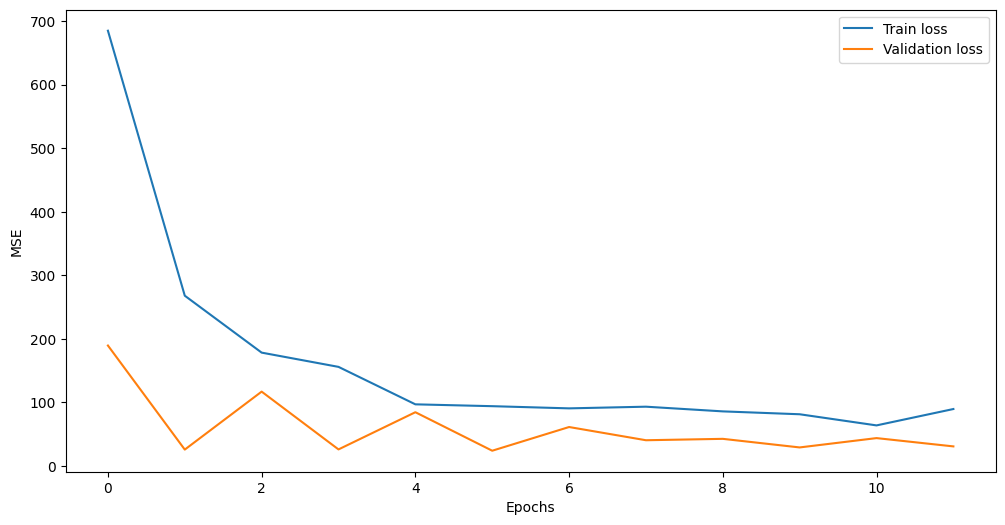

In [11]:
y_pred = model.predict(X_series)
yt_pred = model.predict(Xt_series)

print(f"shapes: {y_pred.shape} {y_pred.shape}")
print(
    f"RMSE train: {mean_squared_error(train_df_scaled[TARGET].iloc[LAGS:-LAGS], y_pred, squared=False):0.02f}"
)
print(
    f"RMSE test: {mean_squared_error(test_df_scaled[TARGET].iloc[LAGS:-LAGS], yt_pred, squared=False):0.02f}"
)
print(f"SMAPE train: {smape(train_df_scaled[TARGET].iloc[LAGS:-LAGS], y_pred):0.02f}%")
print(f"SMAPE test: {smape(test_df_scaled[TARGET].iloc[LAGS:-LAGS], yt_pred):0.02f}%")

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()  # VGG16

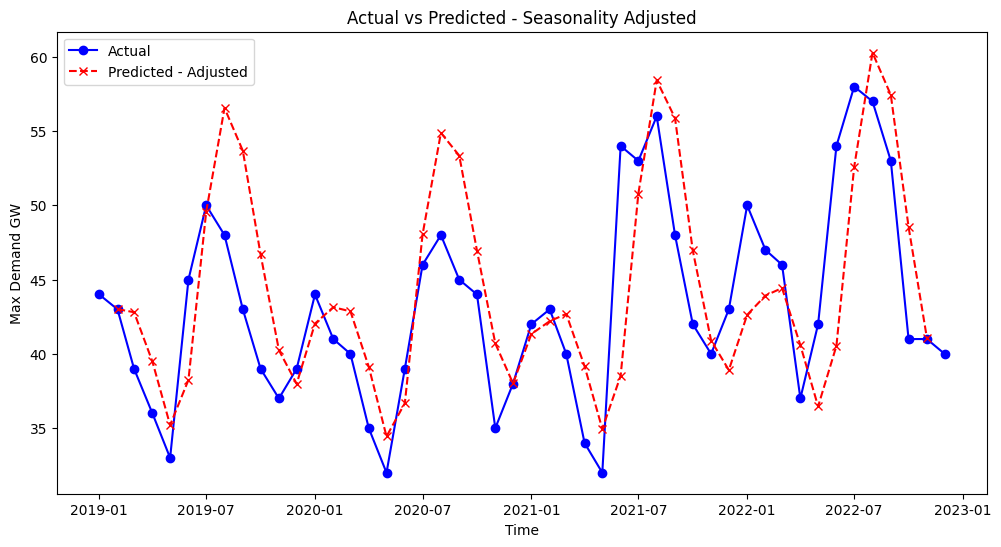

In [13]:
y_pred_adjusted = np.copy(y_pred)
yt_pred_adjusted = np.copy(yt_pred)

def add_seasonal_weights(y):
    for i in range(len(y)):
        month = (i if i < 12 else i % 12) + 1
        y[i] *= df_adjustment[df_adjustment["Month"] == month]["Seasonal"].values[0]
    return y


y_pred_adjusted = add_seasonal_weights(y_pred_adjusted)
yt_pred_adjusted = add_seasonal_weights(yt_pred_adjusted)

plt.figure(figsize=(12, 6))
plt.plot(test_df_scaled[TARGET], label="Actual", color="blue", marker="o")
plt.plot(
    test_df_scaled[TARGET].iloc[TIME_WINDOW:-1].index,
    yt_pred_adjusted,
    label="Predicted - Adjusted",
    color="red",
    linestyle="dashed",
    marker="x",
)

plt.xlabel("Time")
plt.ylabel("Max Demand GW")
plt.title("Actual vs Predicted - Seasonality Adjusted")
plt.legend()
plt.show()